In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snp_147 (110).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snap1_043 (13).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Sn1ap_024 (15).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snap_178 - Copy.jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Sap_148 (76).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snp_147 (61).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snap_232.jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snap1_043 (41).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Sap_148 (115).jpg
/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid/Malignant early Pre-B/Snap_075.j

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

In [3]:
train = ImageFolder("/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/train", transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))
train_dl = DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
        
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor([0.8291, 0.8612, 0.9424]), tensor([0.1418, 0.1455, 0.0523]))

In [4]:
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [26]:
train = ImageFolder("/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/train", transform = train_transform)
test = ImageFolder("/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/test",transform = test_transform)

In [27]:
random_seed = 42
torch.manual_seed(random_seed);
#validation size maintaining
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(2594, 648)

In [28]:
batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [29]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

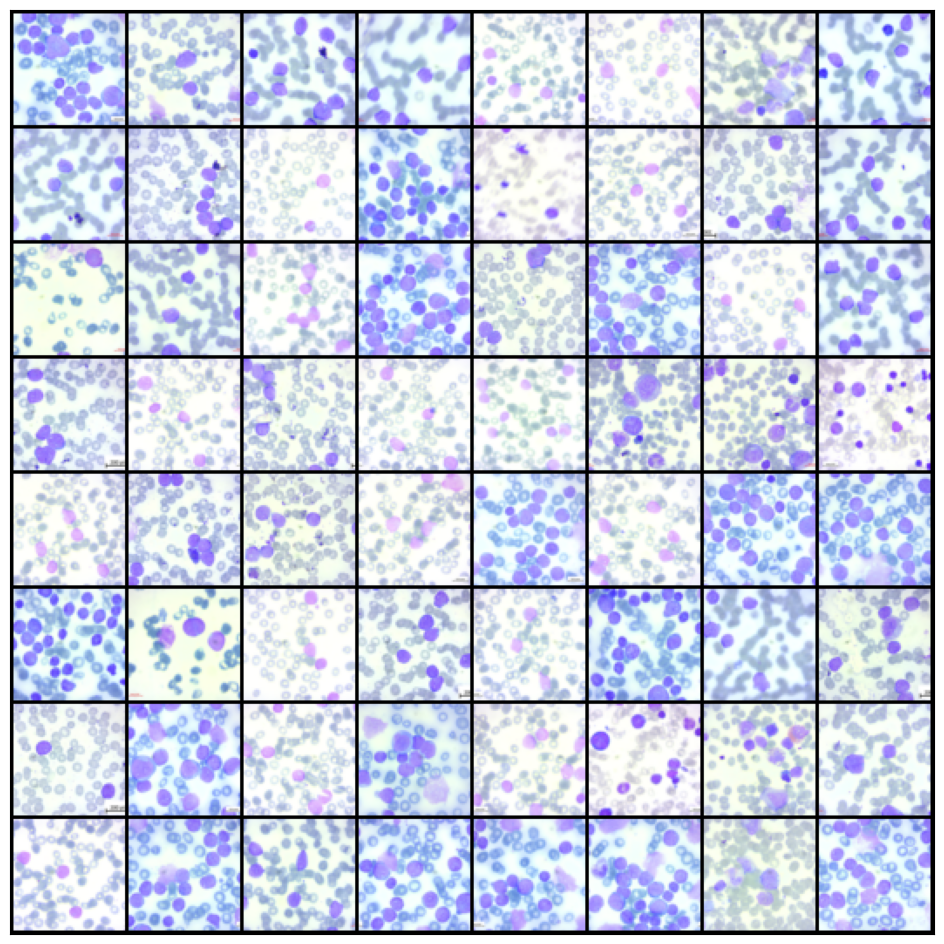

In [30]:
show_batch(train_dl)

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [36]:
no_of_classes = len(train.classes)
no_of_classes

4

In [37]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3967115879058838, 'val_acc': 0.1507353037595749}]

In [40]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00266, train_loss: 0.5718, val_loss: 3.7020, val_acc: 0.6536
Epoch [1], last_lr: 0.00753, train_loss: 0.1592, val_loss: 38.2836, val_acc: 0.1494
Epoch [2], last_lr: 0.01000, train_loss: 0.3235, val_loss: 23.5947, val_acc: 0.3908
Epoch [3], last_lr: 0.00950, train_loss: 0.1091, val_loss: 2.4713, val_acc: 0.6481
Epoch [4], last_lr: 0.00812, train_loss: 0.1382, val_loss: 0.4437, val_acc: 0.8702
Epoch [5], last_lr: 0.00611, train_loss: 0.1284, val_loss: 1.9248, val_acc: 0.6877
Epoch [6], last_lr: 0.00389, train_loss: 0.0582, val_loss: 2.0080, val_acc: 0.6680
Epoch [7], last_lr: 0.00188, train_loss: 0.0393, val_loss: 0.0472, val_acc: 0.9798
Epoch [8], last_lr: 0.00050, train_loss: 0.0335, val_loss: 0.0637, val_acc: 0.9796
Epoch [9], last_lr: 0.00000, train_loss: 0.0186, val_loss: 0.0265, val_acc: 0.9887
CPU times: user 6.34 s, sys: 1.92 s, total: 8.26 s
Wall time: 7min 38s


In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [43]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [44]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.01532517746090889, 'val_acc': 0.9951171875}

In [45]:
!pip install timm

In [48]:
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
import operator
import torchvision.transforms as transforms 
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

In [49]:
train_dir = "/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/train"
test_dir = "/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/test"
pred_dir = "/kaggle/input/blood-cancer-cell-data/Blood cell Cancer/valid"

BATCH_SIZE = 64
EPOCHS = 5
CLASSES = os.listdir(train_dir)
metric = 0

In [50]:
device = torch.device('cuda')
device

device(type='cuda')

In [51]:
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

In [52]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    if seed == 0 or seed == 1:
        mls_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2], gamma=0.1)
        return criterion, optimizer, lrp_scheduler, mls_scheduler
    else:
        return criterion, optimizer, lrp_scheduler

In [53]:
def model_archive(seed):
    if seed == 0:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=len(CLASSES)),
        )
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed) 
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 1:
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model = model_adjustment(model)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 2:
        model = timm.create_model('ens_adv_inception_resnet_v2', pretrained=True)
        model = model_adjustment(model)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 3:
        model = torchvision.models.densenet201(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 4:
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model = model_adjustment(model)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler

In [54]:
# VGG19 with batch-normalization
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg, mls_scheduler_vgg = model_archive(seed = 0)

# ViT (Vision Transformer)
model_vit, criterion_vit, optimizer_vit, lrp_scheduler_vit, mls_scheduler_vit = model_archive(seed = 1)

# Ensemble Adversarial Inception-ResNet v2
model_eairv, criterion_eairv, optimizer_eairv, lrp_scheduler_eairv = model_archive(seed = 2)

# DenseNet201 classifier
model_dn, criterion_dn, optimizer_dn, lrp_scheduler_dn = model_archive(seed = 3)

# ResNeXt50_32 Classifier
model_rnx, criterion_rnx, optimizer_rnx, lrp_scheduler_rnx = model_archive(seed = 4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 241MB/s]  


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name ens_adv_inception_resnet_v2 to current inception_resnet_v2.tf_ens_adv_in1k.
  model = create_fn(


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 144MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  w

In [55]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [56]:
transform_train_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), inplace=False),
    transforms.RandomApply([AddGaussianNoise(0., 0.156)], p=0.5),
])
transform_test_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
])

In [57]:
config_vit = resolve_data_config({}, model = model_vit)
transform_vit = create_transform(**config_vit)

config_eairv = resolve_data_config({}, model = model_eairv)
transform_eairv = create_transform(**config_eairv)

In [58]:
train_data_v1 = ImageFolder(train_dir, transform = transform_train_v1)
test_data_v1 = ImageFolder(test_dir, transform = transform_test_v1)
#loading data for VGG19 BatchNorm, DenseNet201, ResNeXt50
train_loader_v1 = torch.utils.data.DataLoader(train_data_v1, BATCH_SIZE, shuffle=True)
test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


train_data_vit = ImageFolder(train_dir, transform = transform_vit)
test_data_vit = ImageFolder(test_dir, transform = transform_vit)
#loading data for ViT
train_loader_vit = torch.utils.data.DataLoader(train_data_vit, BATCH_SIZE, shuffle=True)
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


train_data_eairv = ImageFolder(train_dir, transform = transform_eairv)
test_data_eairv = ImageFolder(test_dir, transform = transform_eairv)
#loading data for Ensemble Adversarial Inception-ResNetV2
train_loader_eairv = torch.utils.data.DataLoader(train_data_eairv, BATCH_SIZE, shuffle=True)
test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [59]:
def predictions_df(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            for i in range(len(labels)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1

    print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

In [60]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, seed, model_name, lrp_scheduler, mls_scheduler=None):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        else:
            model.eval()
            test_loss = []
            test_total = 0
            test_correct = 0
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, test_predict = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
                test_total += targets.size(0)
                test_correct += (test_predict == targets).sum().item()
            #get train and test loss
            test_loss = np.mean(test_loss)
            train_loss = np.mean(train_loss)
            #scheduler ReduceLROnPlateau and MultiStepLR
            lrp_scheduler.step(metric)
            if seed == 0 or seed == 1:
                mls_scheduler.step()
            ###    
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Acc: {(100*train_correct/train_total):.4f}, \
                    Test Loss: {test_loss:.4f}, Test Acc: {(100*test_correct/test_total):.4f}, Duration: {dt}')
    return train_losses, test_losses

In [61]:
print('Model: VGG-19-BN')
loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader_v1, test_loader_v1, EPOCHS, 0, 'vgg_dict.pth', lrp_scheduler_vgg, mls_scheduler_vgg)
print('\nModel: DenseNet201')
loss_train_dn, loss_test_dn = batch_gd(model_dn, criterion_dn, optimizer_dn, train_loader_v1, test_loader_v1, EPOCHS, 2, 'dn_dict.pth', lrp_scheduler_dn)
print('\nModel: ResNeXt50')
loss_train_rnx, loss_test_rnx = batch_gd(model_rnx, criterion_rnx, optimizer_rnx, train_loader_v1, test_loader_v1, EPOCHS, 4, 'rnx_dict.pth', lrp_scheduler_rnx)

Model: VGG-19-BN
learning_rate: 0.001
Epoch 1/5, Train Loss: 0.9416, Acc: 80.1974,                     Test Loss: 0.0318, Test Acc: 98.7923, Duration: 0:02:08.232727
learning_rate: 0.0001
Epoch 2/5, Train Loss: 0.1031, Acc: 96.1752,                     Test Loss: 0.0155, Test Acc: 99.6377, Duration: 0:02:07.223260
learning_rate: 0.0001
Epoch 3/5, Train Loss: 0.0716, Acc: 97.5632,                     Test Loss: 0.0108, Test Acc: 99.6377, Duration: 0:02:06.845698
learning_rate: 1e-05
Epoch 4/5, Train Loss: 0.0490, Acc: 98.1493,                     Test Loss: 0.0064, Test Acc: 99.7585, Duration: 0:02:06.598524
learning_rate: 1e-05
Epoch 5/5, Train Loss: 0.0483, Acc: 98.2727,                     Test Loss: 0.0067, Test Acc: 99.6377, Duration: 0:02:07.080748

Model: DenseNet201
learning_rate: 0.001
Epoch 1/5, Train Loss: 0.6802, Acc: 81.4929,                     Test Loss: 0.2232, Test Acc: 94.9275, Duration: 0:02:00.838393
learning_rate: 0.001
Epoch 2/5, Train Loss: 0.2790, Acc: 94.6946,  

In [62]:
print('\nModel: Vision Transformer - ViT')
loss_train_vit, loss_test_vit = batch_gd(model_vit, criterion_vit, optimizer_vit, train_loader_vit, test_loader_vit, EPOCHS, 1, 'vit_dict.pth', lrp_scheduler_vit, mls_scheduler_vit)


Model: Vision Transformer - ViT
learning_rate: 0.001
Epoch 1/5, Train Loss: 0.5149, Acc: 85.3486,                     Test Loss: 0.1873, Test Acc: 97.8261, Duration: 0:02:17.497509
learning_rate: 0.0001
Epoch 2/5, Train Loss: 0.1677, Acc: 97.3782,                     Test Loss: 0.1033, Test Acc: 98.6715, Duration: 0:02:18.705492
learning_rate: 0.0001
Epoch 3/5, Train Loss: 0.1210, Acc: 98.3961,                     Test Loss: 0.1011, Test Acc: 98.9130, Duration: 0:02:19.693321
learning_rate: 1e-05
Epoch 4/5, Train Loss: 0.1156, Acc: 98.6428,                     Test Loss: 0.0963, Test Acc: 98.9130, Duration: 0:02:19.557584
learning_rate: 1e-05
Epoch 5/5, Train Loss: 0.1125, Acc: 98.6120,                     Test Loss: 0.0959, Test Acc: 98.9130, Duration: 0:02:19.731845


In [63]:
print('\nModel: Ensemble Adverserial Inception-Resnet-V2')
loss_train_eairv, loss_test_eairv = batch_gd(model_eairv, criterion_eairv, optimizer_eairv, train_loader_eairv, test_loader_eairv, EPOCHS, 3, 'eairv_dict.pth', lrp_scheduler_eairv)


Model: Ensemble Adverserial Inception-Resnet-V2
learning_rate: 0.001
Epoch 1/5, Train Loss: 0.7681, Acc: 77.7298,                     Test Loss: 0.3699, Test Acc: 89.9758, Duration: 0:02:23.932280
learning_rate: 0.001
Epoch 2/5, Train Loss: 0.3562, Acc: 91.6718,                     Test Loss: 0.2316, Test Acc: 95.2899, Duration: 0:02:24.728781
learning_rate: 0.001
Epoch 3/5, Train Loss: 0.2567, Acc: 94.2320,                     Test Loss: 0.1785, Test Acc: 95.6522, Duration: 0:02:24.018056
learning_rate: 0.0001
Epoch 4/5, Train Loss: 0.2119, Acc: 95.2190,                     Test Loss: 0.1477, Test Acc: 96.2560, Duration: 0:02:23.629358
learning_rate: 0.0001
Epoch 5/5, Train Loss: 0.1845, Acc: 96.2677,                     Test Loss: 0.1445, Test Acc: 96.3768, Duration: 0:02:23.306119


In [64]:
#predictions for each model (pred_hard, pred_soft)
vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df(model_vit, test_loader_vit, transform_vit)
densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)
true_labels = []
#getting true labels
for _, labels in test_loader_v1:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

Number of images Tested= 828
Model Accuracy= 99.63768115942028


Number of images Tested= 828
Model Accuracy= 98.91304347826086


Number of images Tested= 828
Model Accuracy= 98.55072463768117


Number of images Tested= 828
Model Accuracy= 96.37681159420289


Number of images Tested= 828
Model Accuracy= 98.30917874396135




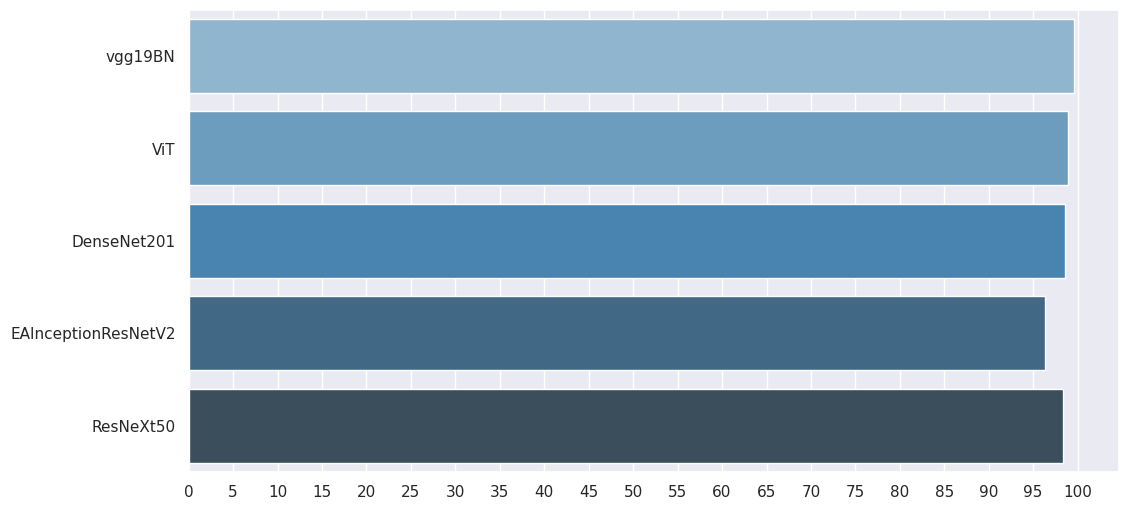

In [65]:
def plot_model_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

In [67]:
def plot_confusion_matrix(preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #getting the standard confusion matrix in text form
    cm = confusion_matrix(np.asarray(true_labels), np.asarray(preds))
    #using the matrix generated as means to plot a confusion matrix graphically
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


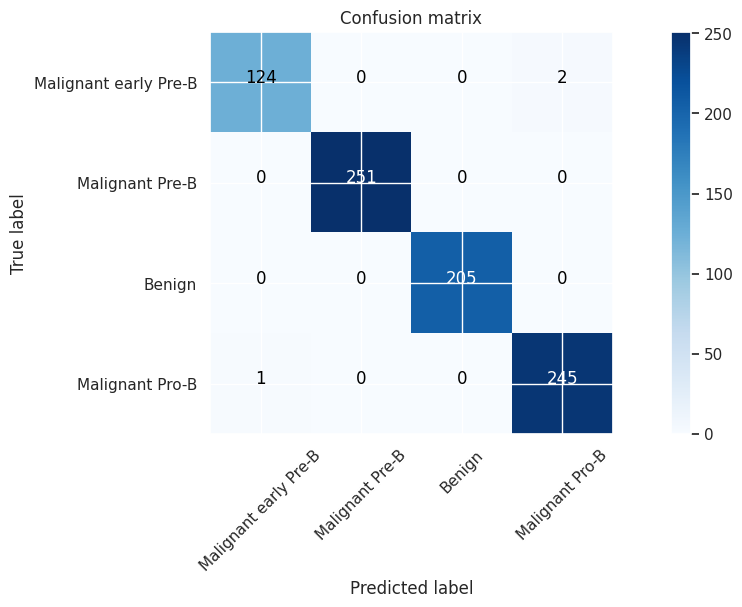

In [68]:
plot_confusion_matrix(vgg19_bn_hard, CLASSES)

Confusion matrix, without normalization


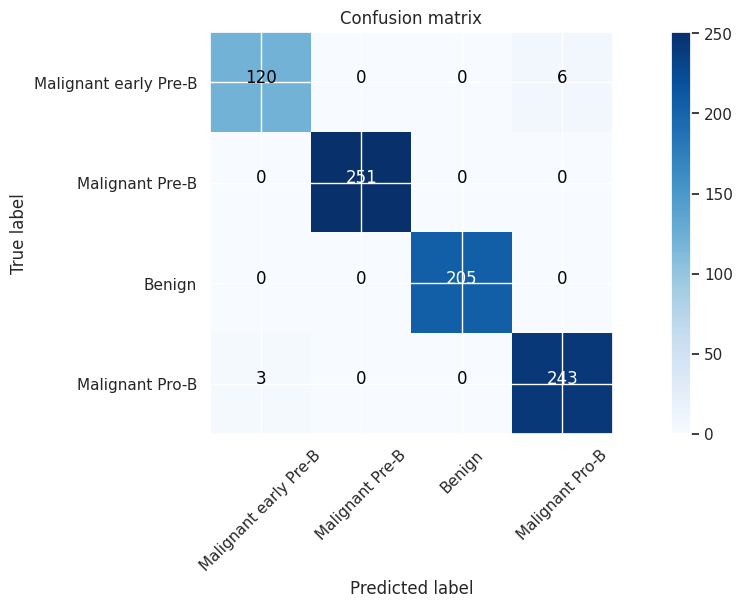

In [69]:
plot_confusion_matrix(vit_hard, CLASSES)

Confusion matrix, without normalization


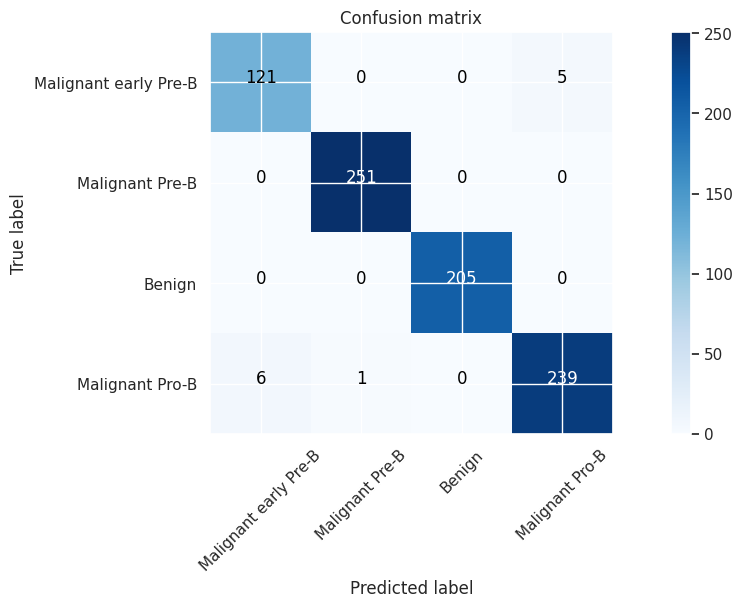

In [70]:
plot_confusion_matrix(densenet201_hard, CLASSES)

Confusion matrix, without normalization


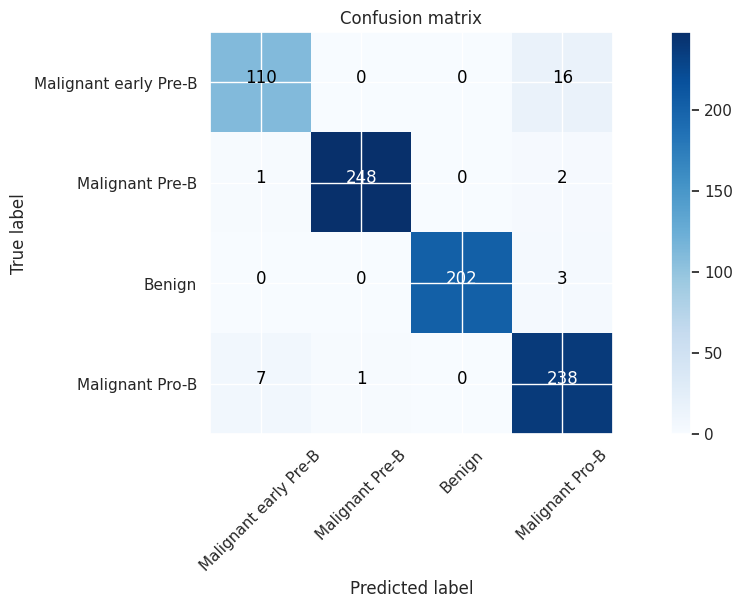

In [71]:
plot_confusion_matrix(ensemble_adv_incres_v2_hard, CLASSES)

Confusion matrix, without normalization


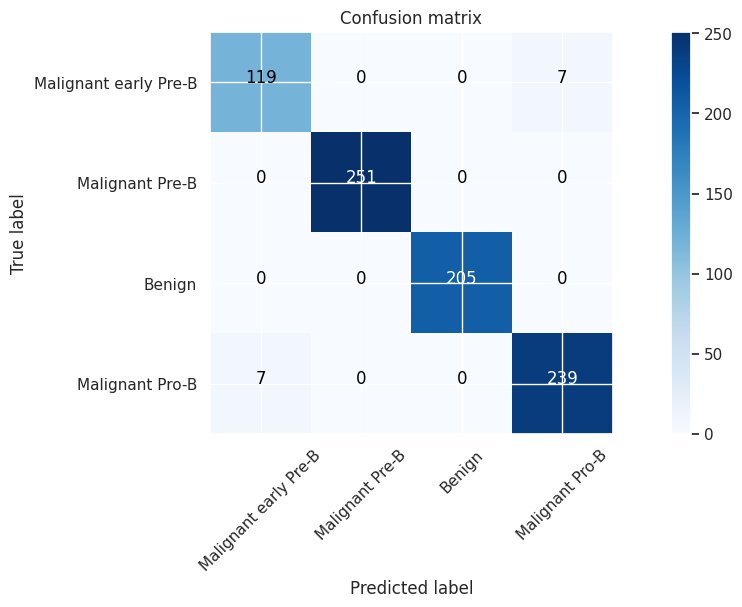

In [72]:
plot_confusion_matrix(resnext50_hard, CLASSES)